<div dir=ltr align=center>In the name of God</div>
<br>
<font size=6><div dir=ltr align=center>
<font size=5>
Intelligent Analysis of
Biomedical Images
<br>
<font size=4>
sharif university of technology, CE department
</font>
<br>
<font size=3>
Dr. Rohban
</font>
<br>
<br>
<font size=6>
Homework 2
</font><br>
<font size=4>


In the following notebook, we use a ct-scan image to create its sinogram, then try to reconstruct the image by applying back projection on the obtained sinogram.

In [3]:
!pip install imutils

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25855 sha256=3f7b076d0bc58dfa91c9941fe4c8c80c941f8e348267aa91e0a931ec93ce4325
  Stored in directory: c:\users\fateme\appdata\local\pip\cache\wheels\31\d0\2c\87ce38f6052879e5b7b18f0f8b4a10ad2a9d210e908d449f16
Successfully built imutils


In [2]:
import numpy as np
import imutils
from skimage.transform import rotate ## Image rotation routine
import scipy.fftpack as fft          ## Fast Fourier Transform
import scipy.misc
from PIL import Image
import matplotlib.pyplot as pyp

In [3]:
ref_image=Image.open('CT-abdomen-400x267.jpg').convert('L')

In [4]:
np.array(ref_image).shape

(267, 400)

In [119]:
import numpy as np
from skimage.transform import rotate 

def radon(image, steps):
    
    angles = np.linspace(0, 180, steps, endpoint=False)
    sinogram = []

    for angle in angles:
        # Rotate image by current angle
        rotated_image = rotate(image, angle, resize=False, order=1)
        
        # Sum the intensities along each column (projection)
        projection = np.sum(rotated_image, axis=0)
        
        # Append the projection to the sinogram
        sinogram.append(projection)

    # Convert sinogram list to a 2D array (steps, image width)
    sinogram = np.array(sinogram)   
    sinogram = np.rot90(sinogram, 2)
    
    return sinogram

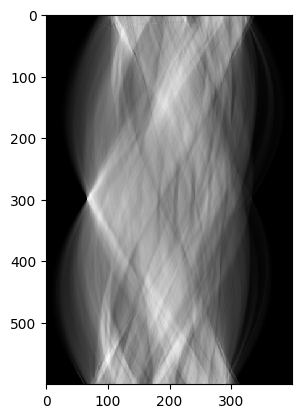

In [120]:
sinogram=radon(np.array(ref_image),600)
pyp.imshow(sinogram,interpolation='nearest',cmap='gray')

In [121]:
from skimage.transform import rotate

def back_project(sinogram):
    num_projections, projection_length = sinogram.shape
    reconstructed_image = np.zeros((projection_length, projection_length))

    # Define the angles at which each projection was taken
    theta = np.linspace(0., 180., num_projections, endpoint=False)
    
    # Back-project each projection
    for i, angle in enumerate(theta):
        # Repeat the projection along rows to create a 2D image
        projection_2d = np.tile(sinogram[i], (projection_length, 1))
        
        # Rotate the projection back to its original angle
        rotated_projection = rotate(projection_2d, angle, resize=False)
        
        # Accumulate the rotated projections to reconstruct the image
        reconstructed_image += rotated_projection

    # Normalize the accumulated image to adjust brightness
    reconstructed_image /= num_projections

    return reconstructed_image

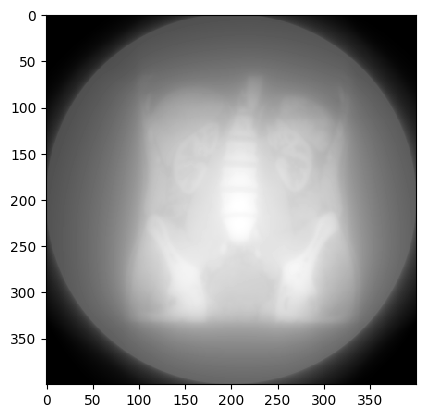

In [122]:
unfiltered_reconstruction = back_project(sinogram)
pyp.imshow(unfiltered_reconstruction,interpolation='nearest',cmap='gray')

In [123]:
def fft_translate(projs):
    #Build 1-d FFTs of an array of projections, each projection 1 row of the array.
    return fft.rfft(projs, axis=1)

In [124]:
def inverse_fft_translate(operator):
    return fft.irfft(operator, axis=1)

In [125]:
frequency_domain_sinogram = fft_translate(sinogram)

In [126]:
def ramp_filter(ffts, epsilon=1e-8):
    num_projections, projection_length = ffts.shape

    # Generate the frequency spectrum for the ramp filter
    freq = np.fft.fftfreq(projection_length).reshape(1, -1)
    ramp = np.abs(freq)

    # Apply the ramp filter to each row (projection) in the FFT array
    filtered_ffts = ffts * ramp

    return filtered_ffts

In [127]:
filtered_frequency_domain_sinogram = ramp_filter(frequency_domain_sinogram)

In [128]:
filtered_spatial_domain_sinogram = inverse_fft_translate(filtered_frequency_domain_sinogram)

In [129]:
reconstructed_image = back_project(filtered_spatial_domain_sinogram)

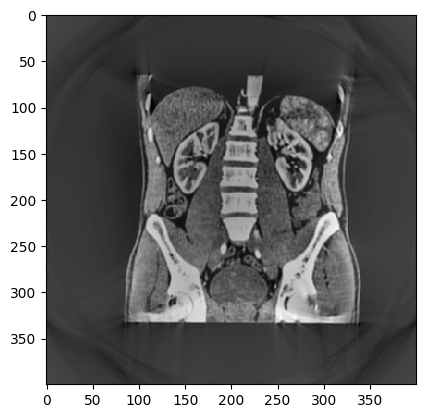

In [130]:
pyp.imshow(reconstructed_image,interpolation='nearest',cmap='gray')